# Imports


In [2]:
# import find_context from baselines/bm25/bm25.py
import random
from urllib import parse
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Helpful Functions


In [3]:
def compute_mrr(rankings, k_values=[1, 5, 10]):
    mrr_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    mrr_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute MRR for each k
    # and compute confidence intervals for each k
    mrr_at_max = {'score': 0, 'cl': [None, None]}
    mrr_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in mrr_at_k_lists.keys():
                if rank <= int(k):
                    mrr_at_k_lists[str(k)][i] += (1 / rank) / len(sample)
            mrr_at_max_list[i] += (1 / rank) / len(sample)
    
    # sort values for confidence intervals
    for k in mrr_at_k_lists.keys():
        mrr_at_k_lists[str(k)].sort()
    mrr_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in mrr_at_k_lists.keys():
        mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
        mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][4] * 1000 // 1 / 1000, mrr_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
    mrr_at_max['cl'] = [mrr_at_max_list[4] * 1000 // 1 / 1000, mrr_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to mrr_at_k
    mrr_at_k['max'] = mrr_at_max

    return mrr_at_k

In [4]:
def compute_stratified_mrr(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in tqdm(zip(rankings, categories), total=len(rankings)):
        ranks_stratified[category].append(rank)
        
    discrete_mrr_at_k = {}
        
    for category in categories_values:
        discrete_mrr_at_k[category] = compute_mrr(ranks_stratified[category], k_values)
        
    return discrete_mrr_at_k

In [5]:
def compute_hits(rankings, k_values=[1, 5, 10]):
    hits_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    hits_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in hits_at_k_lists.keys():
                if rank <= int(k):
                    hits_at_k_lists[str(k)][i] += 1 / len(sample)
    
    # sort values for confidence intervals
    for k in hits_at_k_lists.keys():
        hits_at_k_lists[str(k)].sort()
    
    # find mean score and 90% confidence interval
    for k in hits_at_k_lists.keys():
        hits_at_k[str(k)]['score'] = np.mean(hits_at_k_lists[str(k)]) * 1000 // 1 / 1000
        hits_at_k[str(k)]['cl'] = [hits_at_k_lists[str(k)][4] * 1000 // 1 / 1000, hits_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    
    return hits_at_k

In [6]:
def compute_stratified_hits(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in tqdm(zip(rankings, categories), total=len(rankings)):
        ranks_stratified[category].append(rank)
    
    discrete_hits_at_k = {}
        
    for category in categories_values:
        discrete_hits_at_k[category] = compute_hits(ranks_stratified[category], k_values)
        
    return discrete_hits_at_k

In [7]:
def compute_ndcg(rankings, k_values=[1, 5, 10]):
    ndcg_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    ndcg_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute NDCG for each k
    # and compute confidence intervals for each k
    ndcg_at_max = {'score': 0, 'cl': [None, None]}
    ndcg_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in ndcg_at_k_lists.keys():
                if rank <= int(k):
                    ndcg_at_k_lists[str(k)][i] += (1 / np.log2(rank + 1)) / len(sample)
            ndcg_at_max_list[i] += (1 / np.log2(rank + 1)) / len(sample)
    
    # sort values for confidence intervals
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k_lists[str(k)].sort()
    ndcg_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
        ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][4] * 1000 // 1 / 1000, ndcg_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
    ndcg_at_max['cl'] = [ndcg_at_max_list[4] * 1000 // 1 / 1000, ndcg_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to ndcg_at_k
    ndcg_at_k['max'] = ndcg_at_max
    
    return ndcg_at_k

In [8]:
def compute_stratified_ndcg(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in tqdm(zip(rankings, categories), total=len(rankings)):
        ranks_stratified[category].append(rank)
    
    discrete_ndcg_at_k = {}
        
    for category in categories_values:
        discrete_ndcg_at_k[category] = compute_ndcg(ranks_stratified[category], k_values)
        
    return discrete_ndcg_at_k

# Load data


In [9]:
test_df = pd.read_parquet('test_ranking_scores.parquet')
test_df

,source_title,source_lead,target_title,target_lead,link_context,source_section,context_span_start_index,context_span_end_index,context_sentence_start_index,context_sentence_end_index,...,noise_strategy_neg_18,source_section_neg_18,random_rank,bm25_rank,exact_match_rank,model_ranking_corruption_rank,model_ranking_no_corruption_rank,fuzzy_match_rank,model_random_section_rank,bm25_mentions_rank
54325,Villarsel-sur-Marly,Villarsel-sur-Marly is a municipality of the d...,Canton of Fribourg,Fribourg is one of the twenty-six cantons of S...,Villarsel-sur-Marly is a municipality of the d...,Lead,0,104,0,104,...,no_mask,Championships,12,1,1,1,1,1,1,1
29170,March 15,March 15 is the 74th day of the year in the Gr...,Producer,A producer is something or somebody that creat...,"1952 - Howard Koh, American politician\n1952 -...",Births,234,306,234,307,...,mask_mention,Lead,18,13,19,1,1,8,1,13
66046,Demi Lovato,Demetria Devonne Lovato is an American singer-...,Sandy Hook Elementary School shooting,The Sandy Hook Elementary School shooting was ...,The series was cancelled after one season. In ...,Acting career,0,826,546,716,...,no_mask,Chess databases,14,1,1,5,5,1,5,1
83159,December 18,December 18 is the 352nd day of the year in th...,1969,1969 (MCMLXIX) was a common year starting on W...,"1857)\nč\nć\n1954 - Pedro Luna, Chilean painte...",Deaths,55,104,55,98,...,mask_mention,Lead,13,16,10,1,1,4,1,16
27104,Country,A country is a distinct territory with defined...,Taiwan,"Republic of China, is a Chinese regime that mi...",Disputed countries,Disputed countries,19,664,19,53,...,mask_span,Lead,14,18,19,1,7,20,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48226,1994,1994 (MCMXCIV) was a common year starting on S...,February 14,February 14 is the 45th day of the year in the...,"Births\nJanuary 21 – Laura Robson, British ten...",Births,56,98,56,99,...,mask_mention,Deaths,18,6,1,1,3,1,1,1
24821,March 26,March 26 is the 85th day of the year in the Gr...,United Kingdom,The United Kingdom of Great Britain and Northe...,1971 – East Pakistan declares independence und...,Events,328,404,328,405,...,no_mask,Births,3,9,5,1,1,5,1,5
77724,Egnach,Egnach is a municipality of the district of Ar...,Cantons of Switzerland,Switzerland is divided into 26 different areas...,Egnach is a municipality of the district of Ar...,Lead,0,115,0,90,...,no_mask,Related pages,1,3,1,1,1,1,1,1
122078,2021,2021 (MMXXI) was a common year starting on Fri...,Vice President of the United States,The vice president of the United States is the...,Dutch Prime Minister Mark Rutte and his govern...,Events,440,588,440,589,...,mask_mention,Lead,13,1,1,1,1,9,1,1


In [11]:
mask = test_df['link_context_neg_0'] != test_df['link_context_neg_1']
for i in range(0, 19):
    for j in range(i + 1, 19):
        mask = mask & (test_df['link_context_neg_' + str(i)] != test_df['link_context_neg_' + str(j)])
test_df = test_df[mask]

# Apply Model Trained with Listwise Softmax and Corruption Techniques, but with a random section title

## Compute MRR@k, Hits@k, NDCG@k

In [12]:
mrr_at_k_model_random_section = compute_mrr(test_df['model_random_section_rank'].tolist())
stratified_mrr_at_k_model_random_section = compute_stratified_mrr(test_df['model_random_section_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 941357.27it/s]


In [13]:
hits_at_k_model_random_section = compute_hits(test_df['model_random_section_rank'].tolist())
stratified_hits_at_k_model_random_section = compute_stratified_hits(test_df['model_random_section_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2363426.16it/s]


In [14]:
ndcg_at_k_model_random_section = compute_ndcg(test_df['model_random_section_rank'].tolist())
stratified_ndcg_at_k_model_random_section = compute_stratified_ndcg(test_df['model_random_section_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2175884.67it/s]


In [15]:
rank_std_model_random_section = test_df['model_random_section_rank'].std()
stratified_rank_std_model_random_section = test_df.groupby('noise_strategy')['model_random_section_rank'].std()

# Apply Model Trained with Listwise Softmax and with Corruption Techniques

# Compute MRR@k, Hits@k, NDCG@k

In [16]:
mrr_at_k_model_softmax_corruption = compute_mrr(test_df['model_ranking_corruption_rank'].tolist())
stratified_mrr_at_k_model_softmax_corruption = compute_stratified_mrr(test_df['model_ranking_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1676618.56it/s]


In [17]:
hits_at_k_model_softmax_corruption = compute_hits(test_df['model_ranking_corruption_rank'].tolist())
stratified_hits_at_k_model_softmax_corruption = compute_stratified_hits(test_df['model_ranking_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1342884.06it/s]


In [18]:
ndcg_at_k_model_softmax_corruption = compute_ndcg(test_df['model_ranking_corruption_rank'].tolist())
stratified_ndcg_at_k_model_softmax_corruption = compute_stratified_ndcg(test_df['model_ranking_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1914517.14it/s]

In [19]:
rank_std_model_softmax_corruption = test_df['model_ranking_corruption_rank'].std()
stratified_rank_std_model_softmax_corruption = test_df.groupby('noise_strategy')['model_ranking_corruption_rank'].std().to_dict()

# Apply Model Trained with Listwise Softmax and without Corruption Techniques

# Compute MRR@k, Hits@k, NDCG@k

In [20]:
mrr_at_k_model_softmax_no_corruption = compute_mrr(test_df['model_ranking_no_corruption_rank'].tolist())
stratified_mrr_at_k_model_softmax_no_corruption = compute_stratified_mrr(test_df['model_ranking_no_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1676618.56it/s]


In [21]:
hits_at_k_model_softmax_no_corruption = compute_hits(test_df['model_ranking_no_corruption_rank'].tolist())
stratified_hits_at_k_model_softmax_no_corruption = compute_stratified_hits(test_df['model_ranking_no_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2433336.67it/s]


In [22]:
ndcg_at_k_model_softmax_no_corruption = compute_ndcg(test_df['model_ranking_no_corruption_rank'].tolist())
stratified_ndcg_at_k_model_softmax_no_corruption = compute_stratified_ndcg(test_df['model_ranking_no_corruption_rank'].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2283023.13it/s]


In [23]:
rank_std_model_softmax_no_corruption = test_df['model_ranking_no_corruption_rank'].std()
stratified_rank_std_model_softmax_no_corruption = test_df.groupby('noise_strategy')['model_ranking_no_corruption_rank'].std().to_dict()

# Apply Random Guesser


## Compute MRR@k, Hits@k, NDCG@k


In [24]:
mrr_at_k_random = compute_mrr(test_df['random_rank'].tolist())
stratified_mrr_at_k_random = compute_stratified_mrr(test_df['random_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2155652.44it/s]


In [25]:
hits_at_k_random = compute_hits(test_df['random_rank'].tolist())
stratified_hits_at_k_random = compute_stratified_hits(test_df['random_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1438317.45it/s]


In [26]:
ndcg_at_k_random = compute_ndcg(test_df['random_rank'].tolist())
stratified_ndcg_at_k_random = compute_stratified_ndcg(test_df['random_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1783312.47it/s]


In [27]:
rank_std_random = test_df['random_rank'].std()
stratified_rank_std_random = test_df.groupby('noise_strategy')['random_rank'].std()

# Apply BM25


## Compute MRR@k, Hits@k, NDCG@k


In [28]:
mrr_at_k_bm25 = compute_mrr(test_df['bm25_rank'].tolist())
stratified_mrr_at_k_bm25 = compute_stratified_mrr(test_df['bm25_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1086551.70it/s]


In [29]:
hits_at_k_bm25 = compute_hits(test_df['bm25_rank'].tolist())
stratified_hits_at_k_bm25 = compute_stratified_hits(test_df['bm25_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1718421.05it/s]


In [30]:
ndcg_at_k_bm25 = compute_ndcg(test_df['bm25_rank'].tolist())
stratified_ndcg_at_k_bm25 = compute_stratified_ndcg(test_df['bm25_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2006401.91it/s]


In [31]:
rank_std_bm25 = test_df['bm25_rank'].std()
stratified_rank_std_bm25 = test_df.groupby('noise_strategy')['bm25_rank'].std().to_dict()

# Apply BM25 with mention knowledge


## Compute MRR@k, Hits@k, NDCG@k


In [32]:
mrr_at_k_bm25_mention = compute_mrr(test_df['bm25_mentions_rank'].tolist())
stratified_mrr_at_k_bm25_mention = compute_stratified_mrr(test_df['bm25_mentions_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1924631.57it/s]


In [33]:
hits_at_k_bm25_mention = compute_hits(test_df['bm25_mentions_rank'].tolist())
stratified_hits_at_k_bm25_mention = compute_stratified_hits(test_df['bm25_mentions_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1717263.86it/s]


In [34]:
ndcg_at_k_bm25_mention = compute_ndcg(test_df['bm25_mentions_rank'].tolist())
stratified_ndcg_at_k_bm25_mention = compute_stratified_ndcg(test_df['bm25_mentions_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2188958.65it/s]


In [35]:
rank_std_bm25 = test_df['bm25_mentions_rank'].std()
stratified_rank_std_bm25_mention = test_df.groupby('noise_strategy')['bm25_mentions_rank'].std().to_dict()

# Apply Exact Matching


## Compute MRR@k, Hits@k, NDCG@k


In [36]:
mrr_at_k_exact = compute_mrr(test_df['exact_match_rank'].tolist())
stratified_mrr_at_k_exact = compute_stratified_mrr(test_df['exact_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1767246.59it/s]


In [37]:
hits_at_k_exact = compute_hits(test_df['exact_match_rank'].tolist())
stratified_hits_at_k_exact = compute_stratified_hits(test_df['exact_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1083781.06it/s]


In [38]:
ndcg_at_k_exact = compute_ndcg(test_df['exact_match_rank'].tolist())
stratified_ndcg_at_k_exact = compute_stratified_ndcg(test_df['exact_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1492180.71it/s]


In [39]:
rank_std_exact = test_df['exact_match_rank'].std()
stratified_rank_std_exact = test_df.groupby('noise_strategy')['exact_match_rank'].std()

# Apply Fuzzy Matching


## Compute MRR@k, Hits@k, NDCG@k


In [40]:
mrr_at_k_fuzzy = compute_mrr(test_df['fuzzy_match_rank'].tolist())
stratified_mrr_at_k_fuzzy = compute_stratified_mrr(test_df['fuzzy_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 2202190.70it/s]


In [41]:
hits_at_k_fuzzy = compute_hits(test_df['fuzzy_match_rank'].tolist())
stratified_hits_at_k_fuzzy = compute_stratified_hits(test_df['fuzzy_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1897423.24it/s]


In [42]:
ndcg_at_k_fuzzy = compute_ndcg(test_df['fuzzy_match_rank'].tolist())
stratified_ndcg_at_k_fuzzy = compute_stratified_ndcg(test_df['fuzzy_match_rank'].tolist(
), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique().tolist())

100%|██████████| 608/608 [00:00<00:00, 1509850.11it/s]


In [43]:
rank_std_fuzzy = test_df['fuzzy_match_rank'].std()
stratified_rank_std_fuzzy = test_df.groupby('noise_strategy')['fuzzy_match_rank'].std().to_dict()

# Print all results


In [44]:
print(f"Random guesser rank std: {rank_std_random}")
for category in stratified_rank_std_random.keys():
    print(f"\tRandom guesser rank std for {category}: {stratified_rank_std_random[category]}")
print(f"BM25 rank std: {rank_std_bm25}")
for category in stratified_rank_std_bm25.keys():
    print(f"\tBM25 rank std for {category}: {stratified_rank_std_bm25[category]}")
print(f"BM25 mention rank std: {rank_std_bm25}")
for category in stratified_rank_std_bm25_mention.keys():
    print(f"\tBM25 mention rank std for {category}: {stratified_rank_std_bm25_mention[category]}")    
print(f"Exact match rank std: {rank_std_exact}")
for category in stratified_rank_std_exact.keys():
    print(f"\tExact match rank std for {category}: {stratified_rank_std_exact[category]}")
print(f"Fuzzy match rank std: {rank_std_fuzzy}")
for category in stratified_rank_std_fuzzy.keys():
    print(f"\tFuzzy match rank std for {category}: {stratified_rank_std_fuzzy[category]}")
print(f"Model softmax corruption rank std: {rank_std_model_softmax_corruption}")
for category in stratified_rank_std_model_softmax_corruption.keys():
    print(f"\tModel softmax corruption rank std for {category}: {stratified_rank_std_model_softmax_corruption[category]}")
print(f"Model softmax no corruption rank std: {rank_std_model_softmax_no_corruption}")
for category in stratified_rank_std_model_softmax_no_corruption.keys():
    print(f"\tModel softmax no corruption rank std for {category}: {stratified_rank_std_model_softmax_no_corruption[category]}")
print(f"Model softmax random section rank std: {rank_std_model_random_section}")
for category in stratified_rank_std_model_random_section.keys():
    print(f"\tModel softmax random section rank std for {category}: {stratified_rank_std_model_random_section[category]}")

Random guesser rank std: 5.812907739186006
	Random guesser rank std for mask_mention: 5.656508908488284
	Random guesser rank std for mask_sentence: 5.83911767095913
	Random guesser rank std for mask_span: 5.751811308912465
	Random guesser rank std for no_mask: 5.909487113359858
BM25 rank std: 6.217723168239414
	BM25 rank std for mask_mention: 5.736070924640807
	BM25 rank std for mask_sentence: 6.474699691128593
	BM25 rank std for mask_span: 6.616777616917923
	BM25 rank std for no_mask: 5.183813711095097
BM25 mention rank std: 6.217723168239414
	BM25 mention rank std for mask_mention: 5.60252270943093
	BM25 mention rank std for mask_sentence: 6.6700121462981645
	BM25 mention rank std for mask_span: 6.373307431706682
	BM25 mention rank std for no_mask: 5.15311437463056
Exact match rank std: 5.664703395815143
	Exact match rank std for mask_mention: 6.257336198184771
	Exact match rank std for mask_sentence: 6.489062434250178
	Exact match rank std for mask_span: 6.194702464552969
	Exact mat

# Plot results

## Plot aggregated results

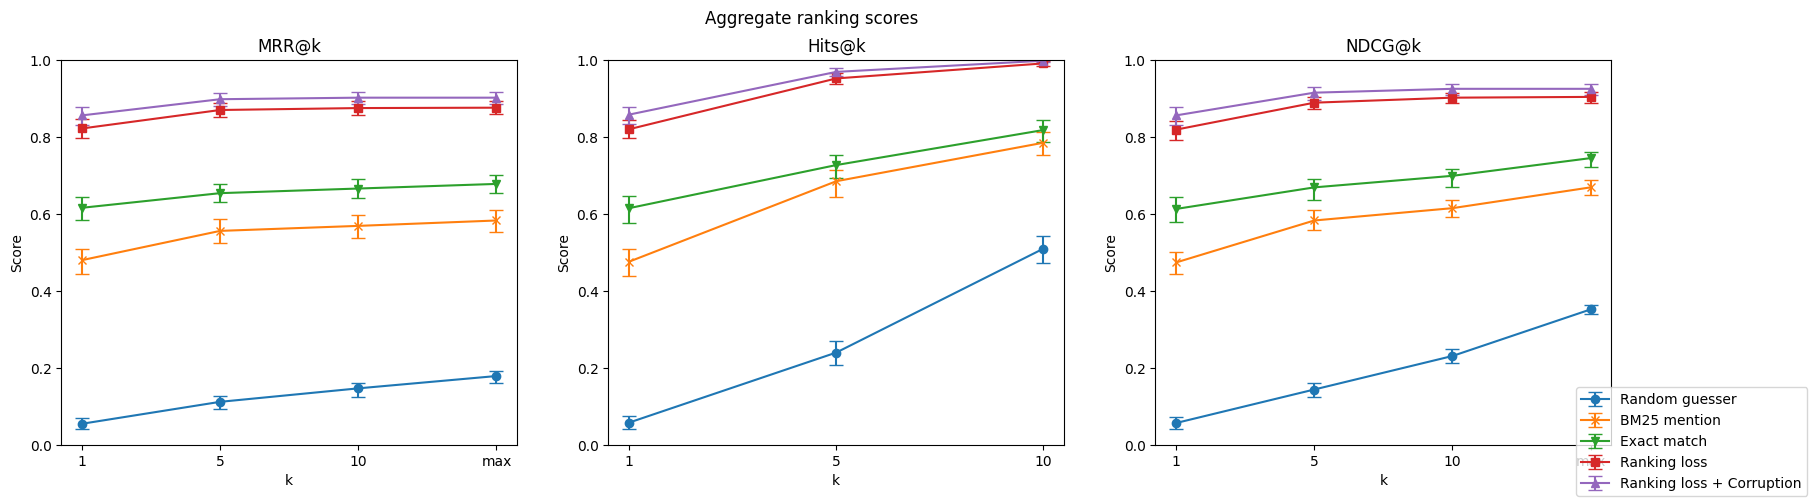

In [45]:
# Plot ranking scores
# create a grid of 1x3 plots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Aggregate ranking scores')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('k')
    ax.set_ylabel('Score')
    
axs[0].set_title('MRR@k')
axs[0].errorbar(mrr_at_k_random.keys(), [mrr_at_k_random[k]['score'] for k in mrr_at_k_random.keys()], yerr=[[mrr_at_k_random[k]['score'] - mrr_at_k_random[k]['cl'][0] for k in mrr_at_k_random.keys()], [mrr_at_k_random[k]['cl'][1] - mrr_at_k_random[k]['score'] for k in mrr_at_k_random.keys()]], label='Random guesser', marker='o', capsize=5)
# axs[0].errorbar(mrr_at_k_bm25.keys(), [mrr_at_k_bm25[k]['score'] for k in mrr_at_k_bm25.keys()], yerr=[[mrr_at_k_bm25[k]['score'] - mrr_at_k_bm25[k]['cl'][0] for k in mrr_at_k_bm25.keys()], [mrr_at_k_bm25[k]['cl'][1] - mrr_at_k_bm25[k]['score'] for k in mrr_at_k_bm25.keys()]], label='BM25', marker='x', capsize=5)
axs[0].errorbar(mrr_at_k_bm25_mention.keys(), [mrr_at_k_bm25_mention[k]['score'] for k in mrr_at_k_bm25_mention.keys()], yerr=[[mrr_at_k_bm25_mention[k]['score'] - mrr_at_k_bm25_mention[k]['cl'][0] for k in mrr_at_k_bm25_mention.keys()], [mrr_at_k_bm25_mention[k]['cl'][1] - mrr_at_k_bm25_mention[k]['score'] for k in mrr_at_k_bm25_mention.keys()]], label='BM25 mention', marker='x', capsize=5)
axs[0].errorbar(mrr_at_k_exact.keys(), [mrr_at_k_exact[k]['score'] for k in mrr_at_k_exact.keys()], yerr=[[mrr_at_k_exact[k]['score'] - mrr_at_k_exact[k]['cl'][0] for k in mrr_at_k_exact.keys()], [mrr_at_k_exact[k]['cl'][1] - mrr_at_k_exact[k]['score'] for k in mrr_at_k_exact.keys()]], label='Exact match', marker='v', capsize=5)
# axs[0].errorbar(mrr_at_k_fuzzy.keys(), [mrr_at_k_fuzzy[k]['score'] for k in mrr_at_k_fuzzy.keys()], yerr=[[mrr_at_k_fuzzy[k]['score'] - mrr_at_k_fuzzy[k]['cl'][0] for k in mrr_at_k_fuzzy.keys()], [mrr_at_k_fuzzy[k]['cl'][1] - mrr_at_k_fuzzy[k]['score'] for k in mrr_at_k_fuzzy.keys()]], label='Fuzzy match', marker='*', capsize=5)
axs[0].errorbar(mrr_at_k_model_softmax_no_corruption.keys(), [mrr_at_k_model_softmax_no_corruption[k]['score'] for k in mrr_at_k_model_softmax_no_corruption.keys()], yerr=[[mrr_at_k_model_softmax_no_corruption[k]['score'] - mrr_at_k_model_softmax_no_corruption[k]['cl'][0] for k in mrr_at_k_model_softmax_no_corruption.keys()], [mrr_at_k_model_softmax_no_corruption[k]['cl'][1] - mrr_at_k_model_softmax_no_corruption[k]['score'] for k in mrr_at_k_model_softmax_no_corruption.keys()]], label='Ranking loss', marker='s', capsize=5)
axs[0].errorbar(mrr_at_k_model_softmax_corruption.keys(), [mrr_at_k_model_softmax_corruption[k]['score'] for k in mrr_at_k_model_softmax_corruption.keys()], yerr=[[mrr_at_k_model_softmax_corruption[k]['score'] - mrr_at_k_model_softmax_corruption[k]['cl'][0] for k in mrr_at_k_model_softmax_corruption.keys()], [mrr_at_k_model_softmax_corruption[k]['cl'][1] - mrr_at_k_model_softmax_corruption[k]['score'] for k in mrr_at_k_model_softmax_corruption.keys()]], label='Ranking loss + Corruption', marker='^', capsize=5)

axs[1].set_title('Hits@k')
axs[1].errorbar(hits_at_k_random.keys(), [hits_at_k_random[k]['score'] for k in hits_at_k_random.keys()], yerr=[[hits_at_k_random[k]['score'] - hits_at_k_random[k]['cl'][0] for k in hits_at_k_random.keys()], [hits_at_k_random[k]['cl'][1] - hits_at_k_random[k]['score'] for k in hits_at_k_random.keys()]], label='Random guesser', marker='o', capsize=5)
# axs[1].errorbar(hits_at_k_bm25.keys(), [hits_at_k_bm25[k]['score'] for k in hits_at_k_bm25.keys()], yerr=[[hits_at_k_bm25[k]['score'] - hits_at_k_bm25[k]['cl'][0] for k in hits_at_k_bm25.keys()], [hits_at_k_bm25[k]['cl'][1] - hits_at_k_bm25[k]['score'] for k in hits_at_k_bm25.keys()]], label='BM25', marker='x', capsize=5)
axs[1].errorbar(hits_at_k_bm25_mention.keys(), [hits_at_k_bm25_mention[k]['score'] for k in hits_at_k_bm25_mention.keys()], yerr=[[hits_at_k_bm25_mention[k]['score'] - hits_at_k_bm25_mention[k]['cl'][0] for k in hits_at_k_bm25_mention.keys()], [hits_at_k_bm25_mention[k]['cl'][1] - hits_at_k_bm25_mention[k]['score'] for k in hits_at_k_bm25_mention.keys()]], label='BM25 mention', marker='x', capsize=5)
axs[1].errorbar(hits_at_k_exact.keys(), [hits_at_k_exact[k]['score'] for k in hits_at_k_exact.keys()], yerr=[[hits_at_k_exact[k]['score'] - hits_at_k_exact[k]['cl'][0] for k in hits_at_k_exact.keys()], [hits_at_k_exact[k]['cl'][1] - hits_at_k_exact[k]['score'] for k in hits_at_k_exact.keys()]], label='Exact match', marker='v', capsize=5)
# axs[1].errorbar(hits_at_k_fuzzy.keys(), [hits_at_k_fuzzy[k]['score'] for k in hits_at_k_fuzzy.keys()], yerr=[[hits_at_k_fuzzy[k]['score'] - hits_at_k_fuzzy[k]['cl'][0] for k in hits_at_k_fuzzy.keys()], [hits_at_k_fuzzy[k]['cl'][1] - hits_at_k_fuzzy[k]['score'] for k in hits_at_k_fuzzy.keys()]], label='Fuzzy match', marker='*', capsize=5)
axs[1].errorbar(hits_at_k_model_softmax_no_corruption.keys(), [hits_at_k_model_softmax_no_corruption[k]['score'] for k in hits_at_k_model_softmax_no_corruption.keys()], yerr=[[hits_at_k_model_softmax_no_corruption[k]['score'] - hits_at_k_model_softmax_no_corruption[k]['cl'][0] for k in hits_at_k_model_softmax_no_corruption.keys()], [hits_at_k_model_softmax_no_corruption[k]['cl'][1] - hits_at_k_model_softmax_no_corruption[k]['score'] for k in hits_at_k_model_softmax_no_corruption.keys()]], label='Ranking loss', marker='s', capsize=5)
axs[1].errorbar(hits_at_k_model_softmax_corruption.keys(), [hits_at_k_model_softmax_corruption[k]['score'] for k in hits_at_k_model_softmax_corruption.keys()], yerr=[[hits_at_k_model_softmax_corruption[k]['score'] - hits_at_k_model_softmax_corruption[k]['cl'][0] for k in hits_at_k_model_softmax_corruption.keys()], [hits_at_k_model_softmax_corruption[k]['cl'][1] - hits_at_k_model_softmax_corruption[k]['score'] for k in hits_at_k_model_softmax_corruption.keys()]], label='Ranking loss + Corruption', marker='^', capsize=5)

axs[2].set_title('NDCG@k')
axs[2].errorbar(ndcg_at_k_random.keys(), [ndcg_at_k_random[k]['score'] for k in ndcg_at_k_random.keys()], yerr=[[ndcg_at_k_random[k]['score'] - ndcg_at_k_random[k]['cl'][0] for k in ndcg_at_k_random.keys()], [ndcg_at_k_random[k]['cl'][1] - ndcg_at_k_random[k]['score'] for k in ndcg_at_k_random.keys()]], label='Random guesser', marker='o', capsize=5)
# axs[2].errorbar(ndcg_at_k_bm25.keys(), [ndcg_at_k_bm25[k]['score'] for k in ndcg_at_k_bm25.keys()], yerr=[[ndcg_at_k_bm25[k]['score'] - ndcg_at_k_bm25[k]['cl'][0] for k in ndcg_at_k_bm25.keys()], [ndcg_at_k_bm25[k]['cl'][1] - ndcg_at_k_bm25[k]['score'] for k in ndcg_at_k_bm25.keys()]], label='BM25', marker='x', capsize=5)
axs[2].errorbar(ndcg_at_k_bm25_mention.keys(), [ndcg_at_k_bm25_mention[k]['score'] for k in ndcg_at_k_bm25_mention.keys()], yerr=[[ndcg_at_k_bm25_mention[k]['score'] - ndcg_at_k_bm25_mention[k]['cl'][0] for k in ndcg_at_k_bm25_mention.keys()], [ndcg_at_k_bm25_mention[k]['cl'][1] - ndcg_at_k_bm25_mention[k]['score'] for k in ndcg_at_k_bm25_mention.keys()]], label='BM25 mention', marker='x', capsize=5)
axs[2].errorbar(ndcg_at_k_exact.keys(), [ndcg_at_k_exact[k]['score'] for k in ndcg_at_k_exact.keys()], yerr=[[ndcg_at_k_exact[k]['score'] - ndcg_at_k_exact[k]['cl'][0] for k in ndcg_at_k_exact.keys()], [ndcg_at_k_exact[k]['cl'][1] - ndcg_at_k_exact[k]['score'] for k in ndcg_at_k_exact.keys()]], label='Exact match', marker='v', capsize=5)
# axs[2].errorbar(ndcg_at_k_fuzzy.keys(), [ndcg_at_k_fuzzy[k]['score'] for k in ndcg_at_k_fuzzy.keys()], yerr=[[ndcg_at_k_fuzzy[k]['score'] - ndcg_at_k_fuzzy[k]['cl'][0] for k in ndcg_at_k_fuzzy.keys()], [ndcg_at_k_fuzzy[k]['cl'][1] - ndcg_at_k_fuzzy[k]['score'] for k in ndcg_at_k_fuzzy.keys()]], label='Fuzzy match', marker='*', capsize=5)
axs[2].errorbar(ndcg_at_k_model_softmax_no_corruption.keys(), [ndcg_at_k_model_softmax_no_corruption[k]['score'] for k in ndcg_at_k_model_softmax_no_corruption.keys()], yerr=[[ndcg_at_k_model_softmax_no_corruption[k]['score'] - ndcg_at_k_model_softmax_no_corruption[k]['cl'][0] for k in ndcg_at_k_model_softmax_no_corruption.keys()], [ndcg_at_k_model_softmax_no_corruption[k]['cl'][1] - ndcg_at_k_model_softmax_no_corruption[k]['score'] for k in ndcg_at_k_model_softmax_no_corruption.keys()]], label='Ranking loss', marker='s', capsize=5)
axs[2].errorbar(ndcg_at_k_model_softmax_corruption.keys(), [ndcg_at_k_model_softmax_corruption[k]['score'] for k in ndcg_at_k_model_softmax_corruption.keys()], yerr=[[ndcg_at_k_model_softmax_corruption[k]['score'] - ndcg_at_k_model_softmax_corruption[k]['cl'][0] for k in ndcg_at_k_model_softmax_corruption.keys()], [ndcg_at_k_model_softmax_corruption[k]['cl'][1] - ndcg_at_k_model_softmax_corruption[k]['score'] for k in ndcg_at_k_model_softmax_corruption.keys()]], label='Ranking loss + Corruption', marker='^', capsize=5)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

## Plot Stratified Results

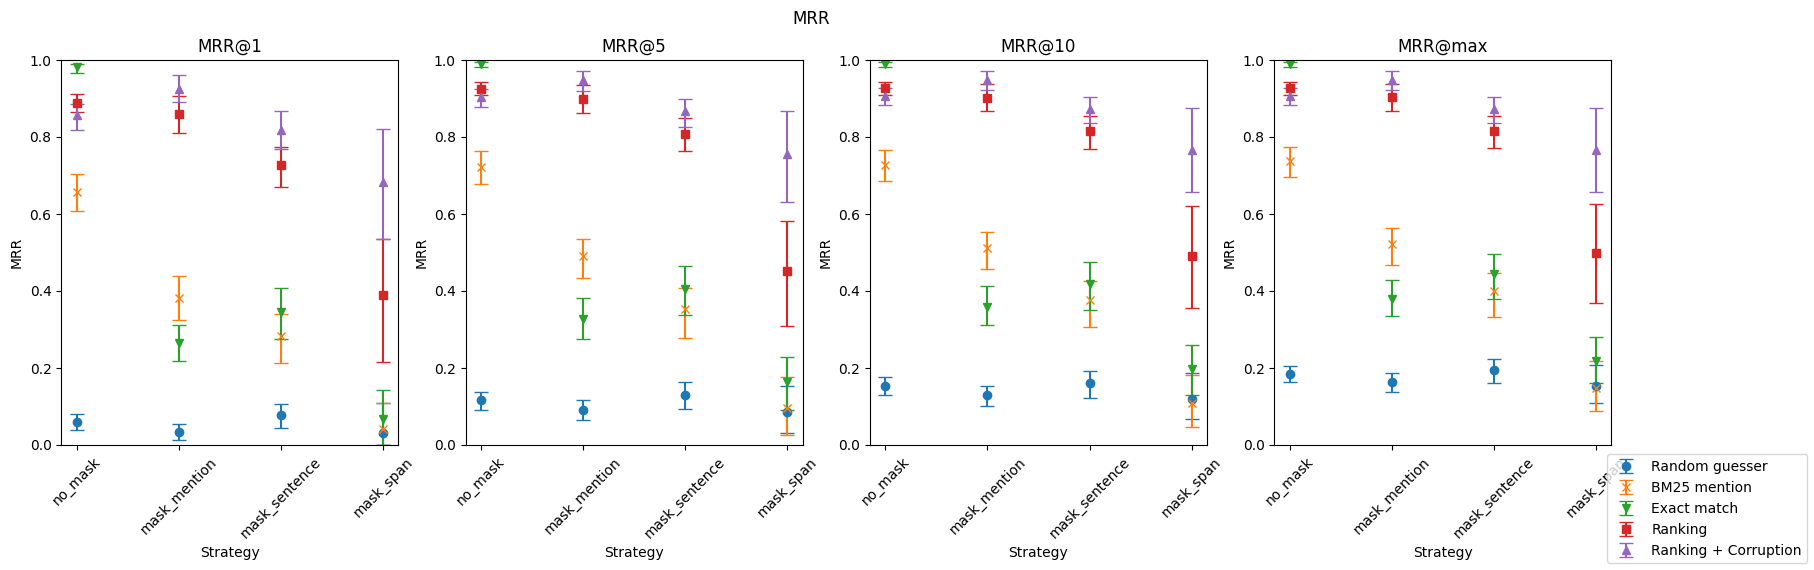

In [46]:
# Plot MRR stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the MRR on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('MRR')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MRR')
    ax.set_title(f"MRR@{list(mrr_at_k_random.keys())[axs.tolist().index(ax)]}")
    
for i, k in enumerate(mrr_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_mrr_at_k_random[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_random[s][k]['score'] - stratified_mrr_at_k_random[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_random[s][k]['cl'][1] - stratified_mrr_at_k_random[s][k]['score'] for s in strategies]], label='Random guesser', marker='o', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_bm25_mention[s][k]['score'] - stratified_mrr_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_bm25_mention[s][k]['cl'][1] - stratified_mrr_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 mention', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_exact[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_exact[s][k]['score'] - stratified_mrr_at_k_exact[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_exact[s][k]['cl'][1] - stratified_mrr_at_k_exact[s][k]['score'] for s in strategies]], label='Exact match', marker='v', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_softmax_no_corruption[s][k]['score'] - stratified_mrr_at_k_model_softmax_no_corruption[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_softmax_no_corruption[s][k]['cl'][1] - stratified_mrr_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies]], label='Ranking', marker='s', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] - stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Ranking + Corruption', marker='^', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

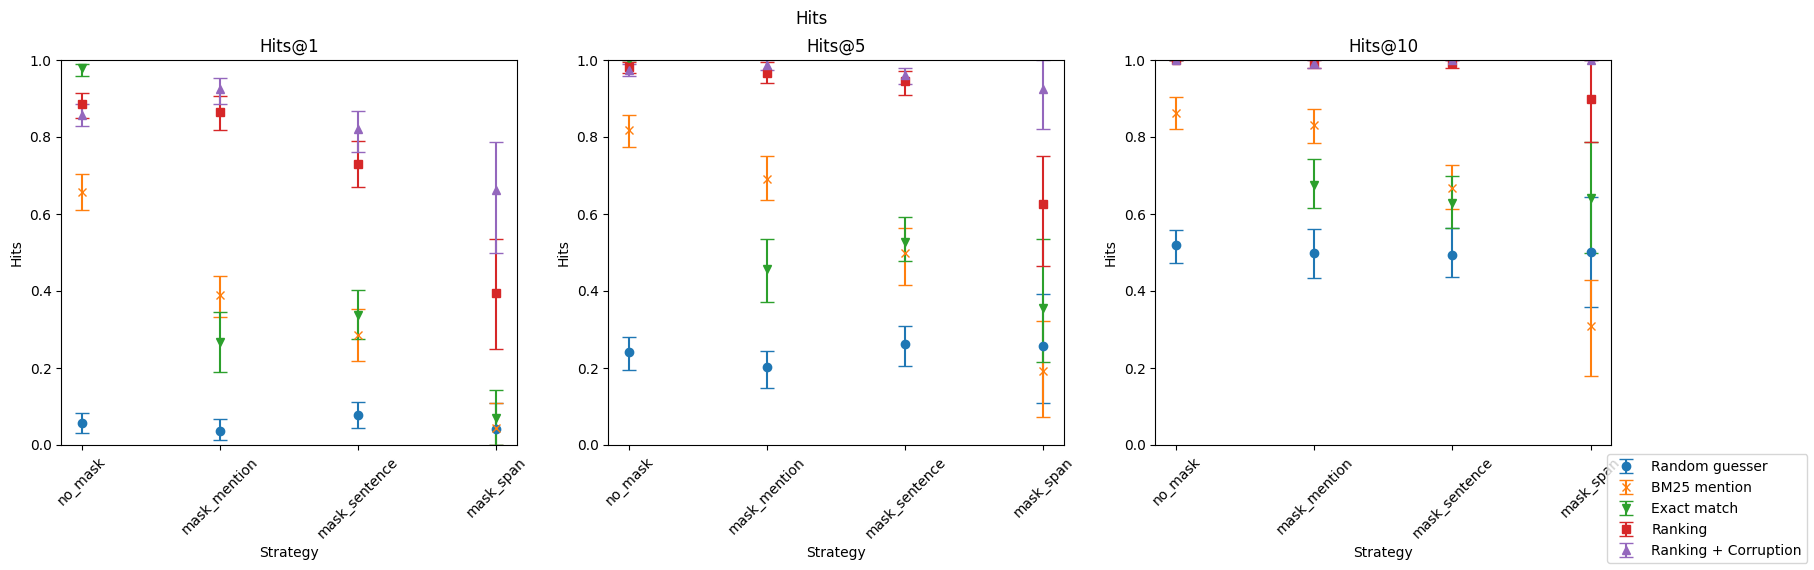

In [47]:
# Plot Hits stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hits')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Hits')
    ax.set_title(f"Hits@{list(hits_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(hits_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_hits_at_k_random[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_random[s][k]['score'] - stratified_hits_at_k_random[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_random[s][k]['cl'][1] - stratified_hits_at_k_random[s][k]['score'] for s in strategies]], label='Random guesser', marker='o', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_bm25_mention[s][k]['score'] - stratified_hits_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_bm25_mention[s][k]['cl'][1] - stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 mention', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_exact[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_exact[s][k]['score'] - stratified_hits_at_k_exact[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_exact[s][k]['cl'][1] - stratified_hits_at_k_exact[s][k]['score'] for s in strategies]], label='Exact match', marker='v', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_model_softmax_no_corruption[s][k]['score'] - stratified_hits_at_k_model_softmax_no_corruption[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_model_softmax_no_corruption[s][k]['cl'][1] - stratified_hits_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies]], label='Ranking', marker='s', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_model_softmax_corruption[s][k]['score'] - stratified_hits_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_hits_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Ranking + Corruption', marker='^', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

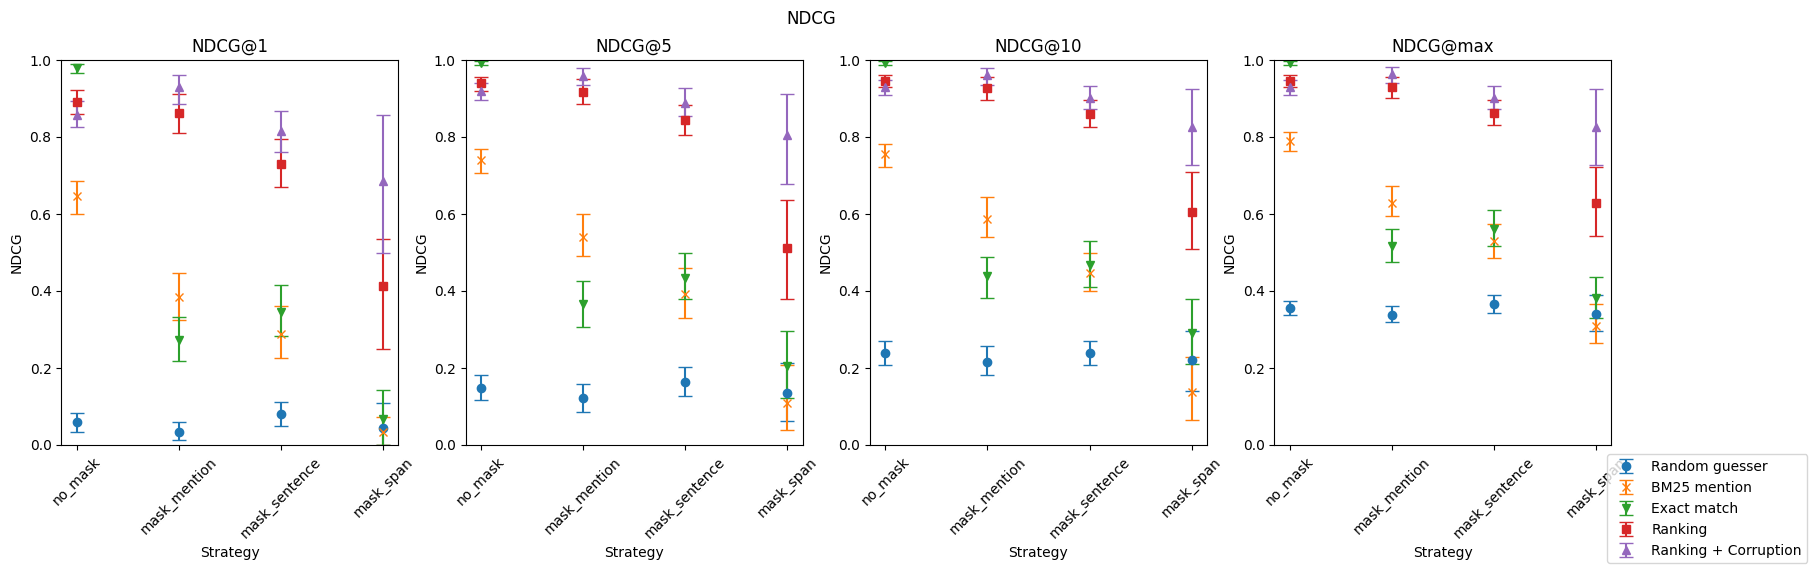

In [48]:
# Plot NDCG stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the ndcg on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('NDCG')

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('NDCG')
    ax.set_title(f"NDCG@{list(ndcg_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(ndcg_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_random[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_random[s][k]['score'] - stratified_ndcg_at_k_random[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_random[s][k]['cl'][1] - stratified_ndcg_at_k_random[s][k]['score'] for s in strategies]], label='Random guesser', marker='o', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_bm25_mention[s][k]['score'] - stratified_ndcg_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_bm25_mention[s][k]['cl'][1] - stratified_ndcg_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 mention', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_exact[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_exact[s][k]['score'] - stratified_ndcg_at_k_exact[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_exact[s][k]['cl'][1] - stratified_ndcg_at_k_exact[s][k]['score'] for s in strategies]], label='Exact match', marker='v', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['score'] - stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['cl'][1] - stratified_ndcg_at_k_model_softmax_no_corruption[s][k]['score'] for s in strategies]], label='Ranking', marker='s', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_ndcg_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k_model_softmax_corruption[s][k]['score'] - stratified_ndcg_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_ndcg_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Ranking + Corruption', marker='^', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')    

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Additional plots

## Compare the full model with the model with random section names

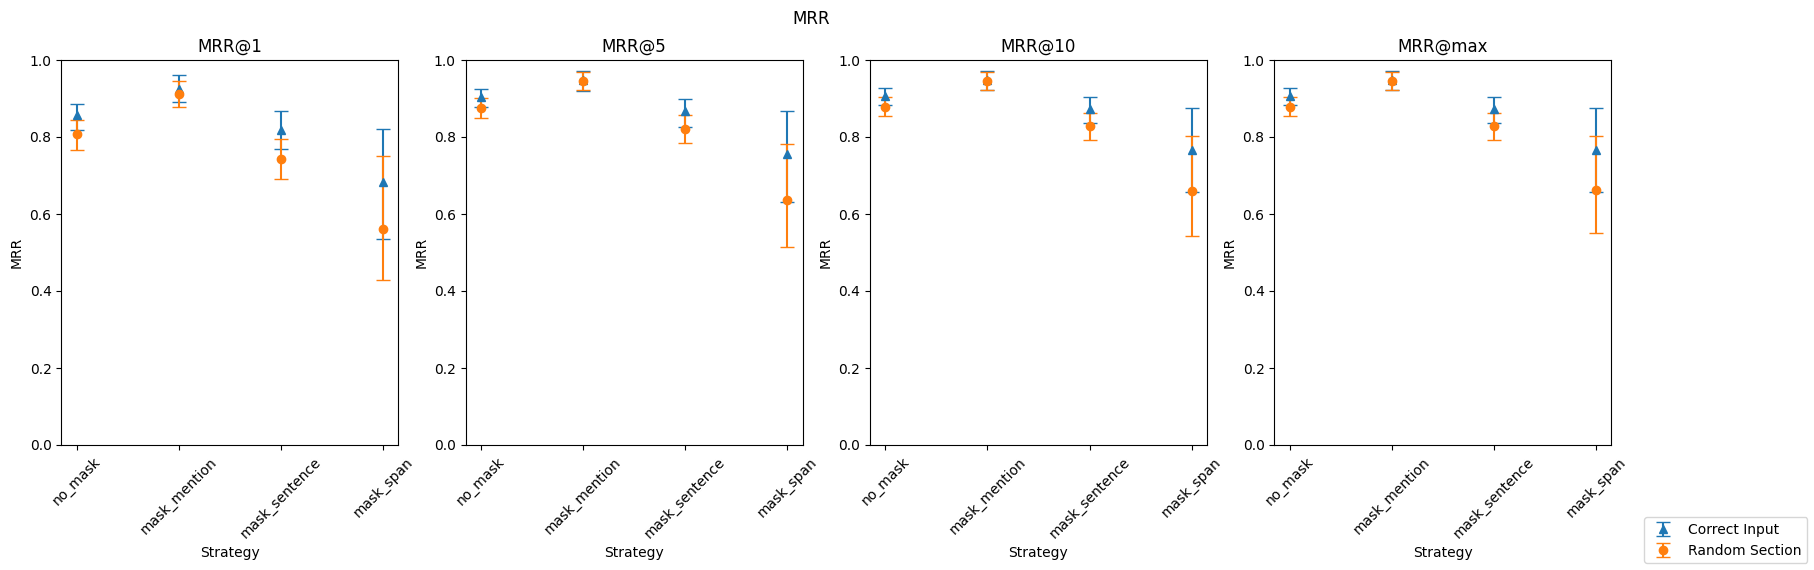

In [53]:
# Plot MRR stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('MRR')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MRR')
    ax.set_title(f"MRR@{list(mrr_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(mrr_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] - stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_softmax_corruption[s][k]['cl'][1] - stratified_mrr_at_k_model_softmax_corruption[s][k]['score'] for s in strategies]], label='Correct Input', marker='^', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_mrr_at_k_model_random_section[s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k_model_random_section[s][k]['score'] - stratified_mrr_at_k_model_random_section[s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k_model_random_section[s][k]['cl'][1] - stratified_mrr_at_k_model_random_section[s][k]['score'] for s in strategies]], label='Random Section', marker='o', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

## Compare Vanilla BM25 with Mention-Aware BM25

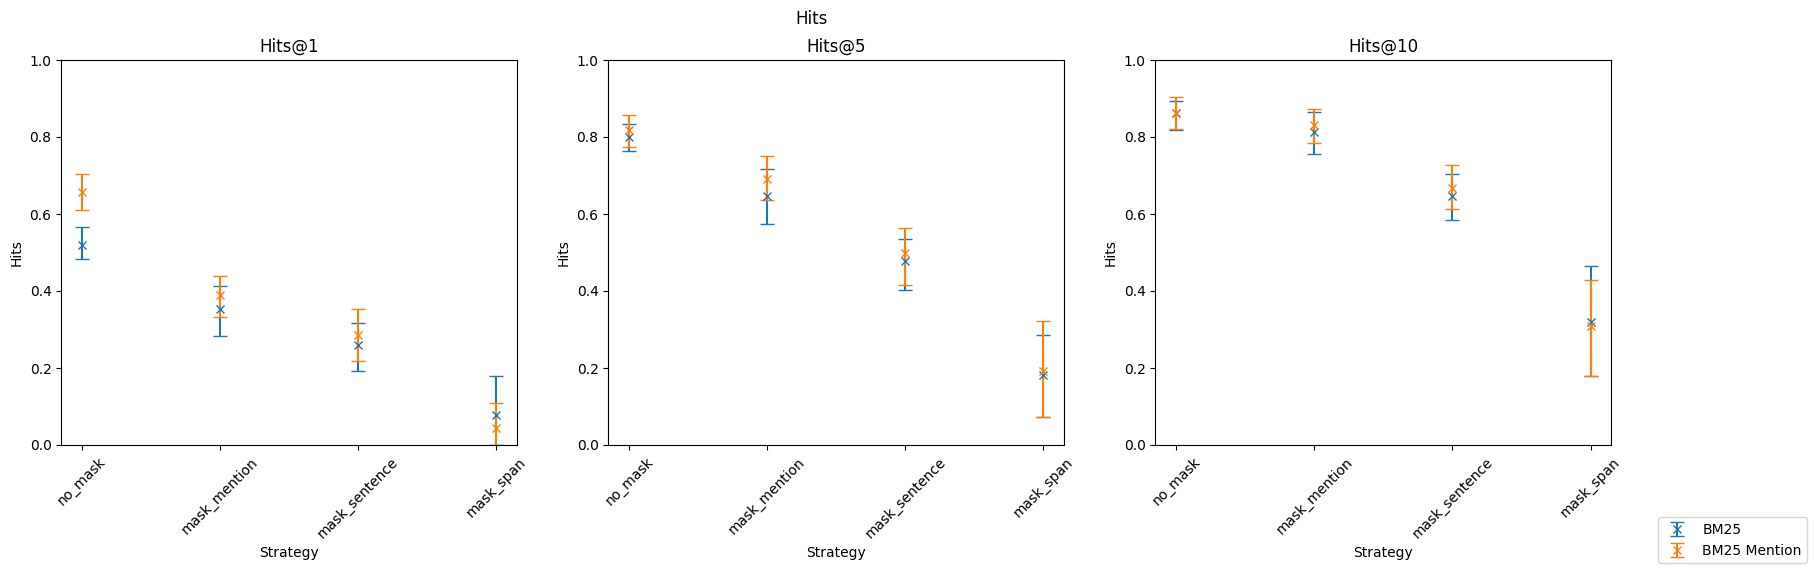

In [50]:
# Plot Hits stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hits')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Hits')
    ax.set_title(f"Hits@{list(hits_at_k_random.keys())[axs.tolist().index(ax)]}")

for i, k in enumerate(hits_at_k_random.keys()):
    axs[i].errorbar(strategies, [stratified_hits_at_k_bm25[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_bm25[s][k]['score'] - stratified_hits_at_k_bm25[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_bm25[s][k]['cl'][1] - stratified_hits_at_k_bm25[s][k]['score'] for s in strategies]], label='BM25', marker='x', capsize=5, linestyle='None')
    axs[i].errorbar(strategies, [stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k_bm25_mention[s][k]['score'] - stratified_hits_at_k_bm25_mention[s][k]['cl'][0] for s in strategies], [stratified_hits_at_k_bm25_mention[s][k]['cl'][1] - stratified_hits_at_k_bm25_mention[s][k]['score'] for s in strategies]], label='BM25 Mention', marker='x', capsize=5, linestyle='None')
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)